In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from matplotlib import __version__ as mplv
from matplotlib.ticker import MultipleLocator, FixedLocator
from matplotlib.patches import Rectangle, Polygon
from matplotlib.collections import PatchCollection
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop

In [2]:
def CropTransformShowDigits(src, pnts, dstsize, decimalsub=None, imshow=False, roi=None):
    '''
    input
        src: 元画像
        roi: タプル, (xmin, xmax, ymin, ymax) 左上原点でxは水平方向、yは垂直方向
        pnts: 元画像の切り出し範囲　4点(x,y)のリストかタプル , (左上, 右上, 右下, 左下)
        dstsize: タプル, (height, width) 切り出し後のサイズ
        decimalsub: タプル,  小数点を消すために暗いピクセルの値を代入する範囲を指定 (xmin, xmax, ymin, ymax)
        imshow: 結果を表示する際にはTrue
        roi: imshowがTrueのときは元画像のズームにつかう(xmin, xmax, ymin, ymax)
    output
        dst: 切り出して歪み補正をした画像
    '''

    pts1 = np.float32(pnts)
    height, width = dstsize
    pts2 = np.float32([[0, 0], [width,0],  [width, height], [0, height]])

    # 切り出しと歪み補正
    M = cv2.getPerspectiveTransform(pts1, pts2)
    dst = cv2.warpPerspective(src, M, (width, height))

    # 小数点の位置に暗いピクセルの値を代入
    if not decimalsub is None:
        xmin, xmax, ymin, ymax = decimalsub
        dst[ymin:ymax+1, xmin:xmax+1] = dst[0, 0]

    # 結果表示
    if imshow:
        fig, axes = plt.subplots(1,2, figsize=(8, 3))
        xmin, xmax, ymin, ymax = roi
        axes[0].imshow(src[ymin:ymax+1, xmin:xmax+1], cmap=plt.get_cmap('Greys_r'),
                   extent=[xmin-0.5, xmax+0.5, ymax+0.5, ymin-0.5])
        axes[0].add_patch(Polygon(pnts, fc='w', ec=None, alpha=0.5))
        # 明るいところを白く表示するためにはGreysを反転させたGreys_rを使う
        axes[1].imshow(dst, cmap=plt.get_cmap('Greys_r'),)

    return dst

In [3]:
imagepaths = list(Path('').glob('*.png'))

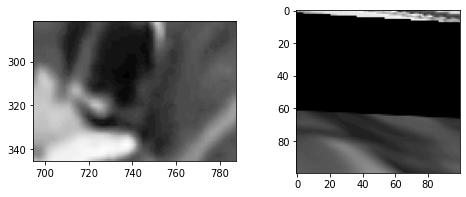

In [46]:
pathstr = str(imagepaths[0])
gray = cv2.imread(pathstr, cv2.IMREAD_GRAYSCALE) # 数字部分が暗い場合は白黒反転が必要

roi_heater = (695, 787, 282, 345)
pnts_heater = [[200, 800], [300, 29], [775, 32], [721, 32]]
decimalpoint_heater = [50, 50, 100, 19]
dstsize = (100, 100)
warped_heater = CropTransformShowDigits(gray, pnts_heater, dstsize, decimalsub=decimalpoint_heater, imshow=True, roi=roi_heater)

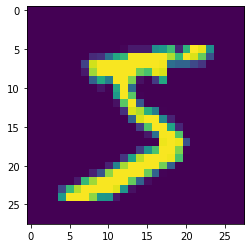

In [59]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
plt.imshow(x_train[0])

In [60]:
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# 0〜255 までの範囲のデータを 0〜1 までの範囲に変更
x_train /= 255
x_test  /= 255

In [64]:
import tensorflow as tf

In [65]:
# 入力層の設定
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((28, 28)))
model.add(tf.keras.layers.Flatten())

In [67]:
# 中間層の設定
model.add(tf.keras.layers.Dense(128)) # 128個に全結合
model.add(tf.keras.layers.Activation(tf.keras.activations.relu)) # 中間層の活性化関数の設定
model.add(tf.keras.layers.Dropout(0.2))

In [68]:
model.add(tf.keras.layers.Dense(10)) # 出力層の設定
model.add(tf.keras.layers.Activation(tf.keras.activations.softmax)) # 出力層の活性化関数の設定

In [70]:
model.compile(
   optimizer=tf.keras.optimizers.Adam(),
   loss=tf.keras.losses.sparse_categorical_crossentropy,
   metrics=[tf.keras.metrics.sparse_categorical_accuracy]
)
model.fit(x_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.2941 - sparse_categorical_accuracy: 0.9143
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1433 - sparse_categorical_accuracy: 0.9569
Epoch 3/5
1875/1875 [==============================] - 2s 979us/step - loss: 0.1084 - sparse_categorical_accuracy: 0.9671
Epoch 4/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0883 - sparse_categorical_accuracy: 0.9724
Epoch 5/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.0748 - sparse_categorical_accuracy: 0.9765


In [71]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 0s 732us/step - loss: 0.0761 - sparse_categorical_accuracy: 0.9764


[0.07611291855573654, 0.9764000177383423]

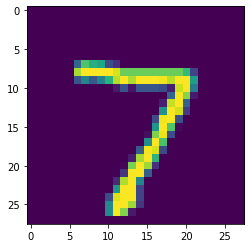

In [72]:
test_data = x_test[0]
plt.imshow(test_data)

In [73]:
print(test_data.shape)
print(test_data[np.newaxis].shape)

(28, 28)
(1, 28, 28)


In [74]:
pred = model.predict(test_data[np.newaxis])
np.argmax(pred)

1/1 [==============================] - 0s 34ms/step


7

In [44]:
from PIL import Image

In [89]:
img = Image.open('').convert('L')

In [90]:
img.thumbnail((28, 28)) # 28*28に変換
img = np.array(img)

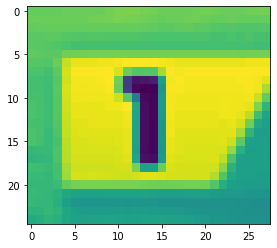

In [91]:
plt.imshow(img)

In [ ]:
from PIL import Image
import pyocr

# OCRエンジンを取得
engines = pyocr.get_available_tools()
engine = engines[0]

# 画像の文字を読み込む
txt = engine.image_to_string(Image.open('moji_en.png'), lang="eng")
print(txt) # 「Test Message」が出力される